In [1]:
from sklearn.metrics import r2_score
from deltalake import DeltaTable
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import itertools
import os

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
four_wheels = lambda x, y: [f'{x}_rear_left_{y}', f'{x}_rear_right_{y}', f'{x}_front_left_{y}', f'{x}_front_right_{y}']

In [18]:
dfs = []
for file_name in os.listdir('delta/segment_results'):
    if file_name.endswith('.parquet'):
        dfs.append(pd.read_parquet('delta/segment_results/' + file_name))
df = pd.concat(dfs)

In [19]:
df['lap_time'] = df['end_lap'] - df['start_lap']
df = df[df['lap_time'] < 90]
df = df.dropna(axis='columns', how='any')

In [20]:
for i in ['rear_left', 'rear_right', 'front_left', 'front_right']:
    df[f'{i}_tyresDamage'] = df[f'max_{i}_tyresDamage'] - df[f'min_{i}_tyresDamage']
    
df['tyres_damage'] = df[['rear_left_tyresDamage', 'rear_right_tyresDamage', 'front_left_tyresDamage', 'front_right_tyresDamage']].apply(lambda x: np.mean(x), axis=1)
df = df[df['tyres_damage'] < 5]

In [21]:
tyresDamage = df.groupby(['driver', 'segment'], as_index=False)[['rear_left_tyresDamage', 'rear_right_tyresDamage', 'front_left_tyresDamage', 'front_right_tyresDamage']].mean()

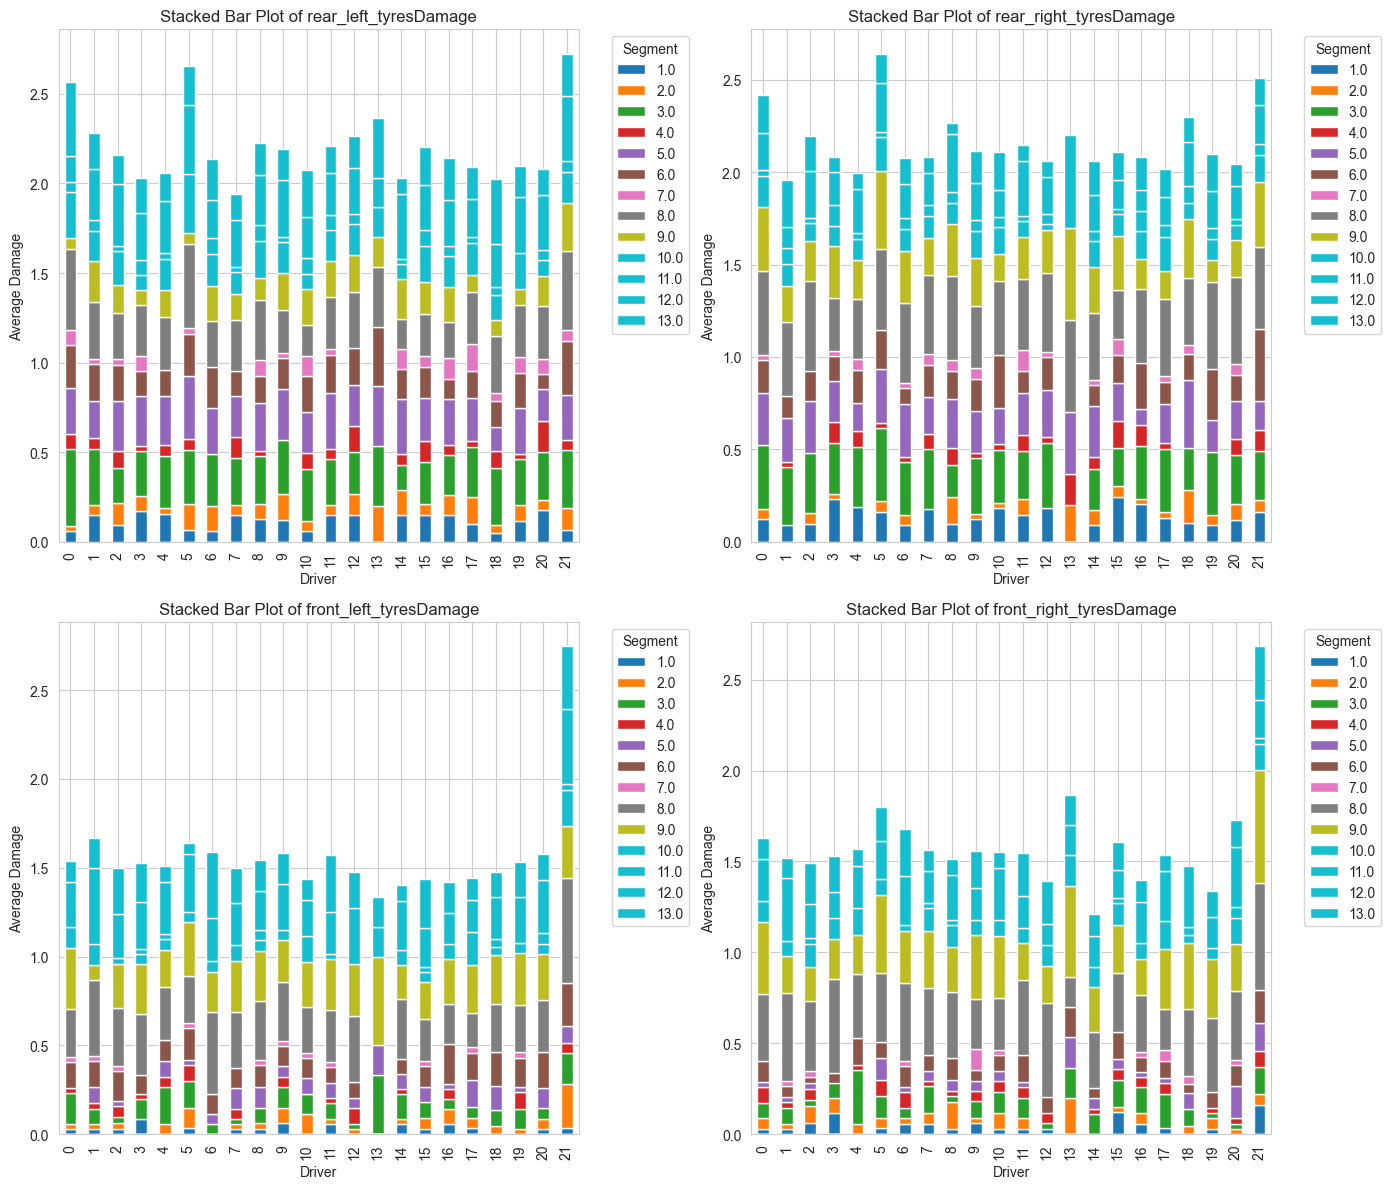

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
segments = tyresDamage['segment'].unique()
colors = plt.cm.tab10(range(len(segments)))
axs = axs.flatten()

columns = ['rear_left_tyresDamage', 'rear_right_tyresDamage', 'front_left_tyresDamage', 'front_right_tyresDamage']

for i, col in enumerate(columns):
    ax = axs[i]
    pivot_df = tyresDamage.pivot(index='driver', columns='segment', values=col).fillna(0)
    pivot_df.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_title(f'Stacked Bar Plot of {col}')
    ax.set_xlabel('Driver')
    ax.set_ylabel('Average Damage')
    ax.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

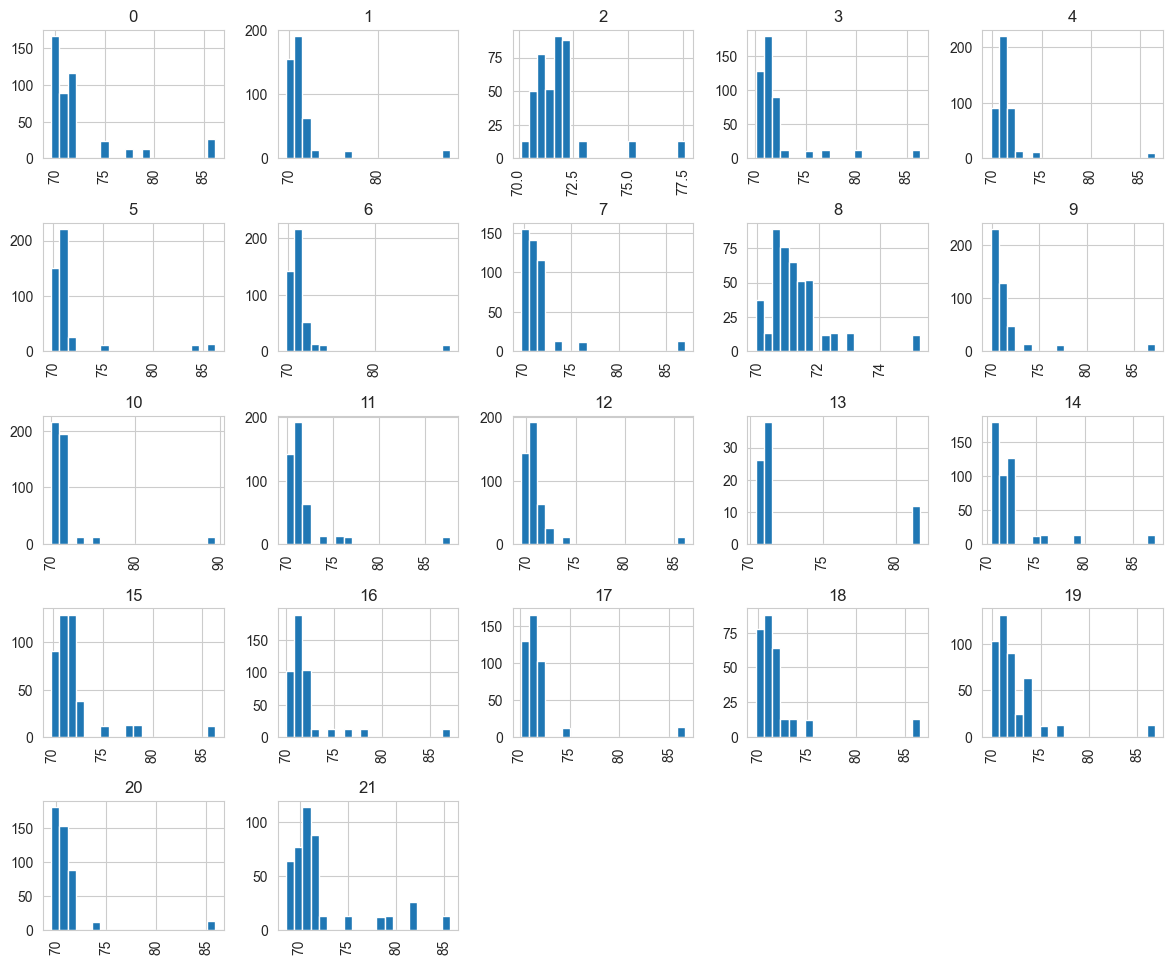

In [23]:
df[['driver', 'lap_time']].hist('lap_time', by='driver', bins=20, figsize=(14, 12))
plt.show()

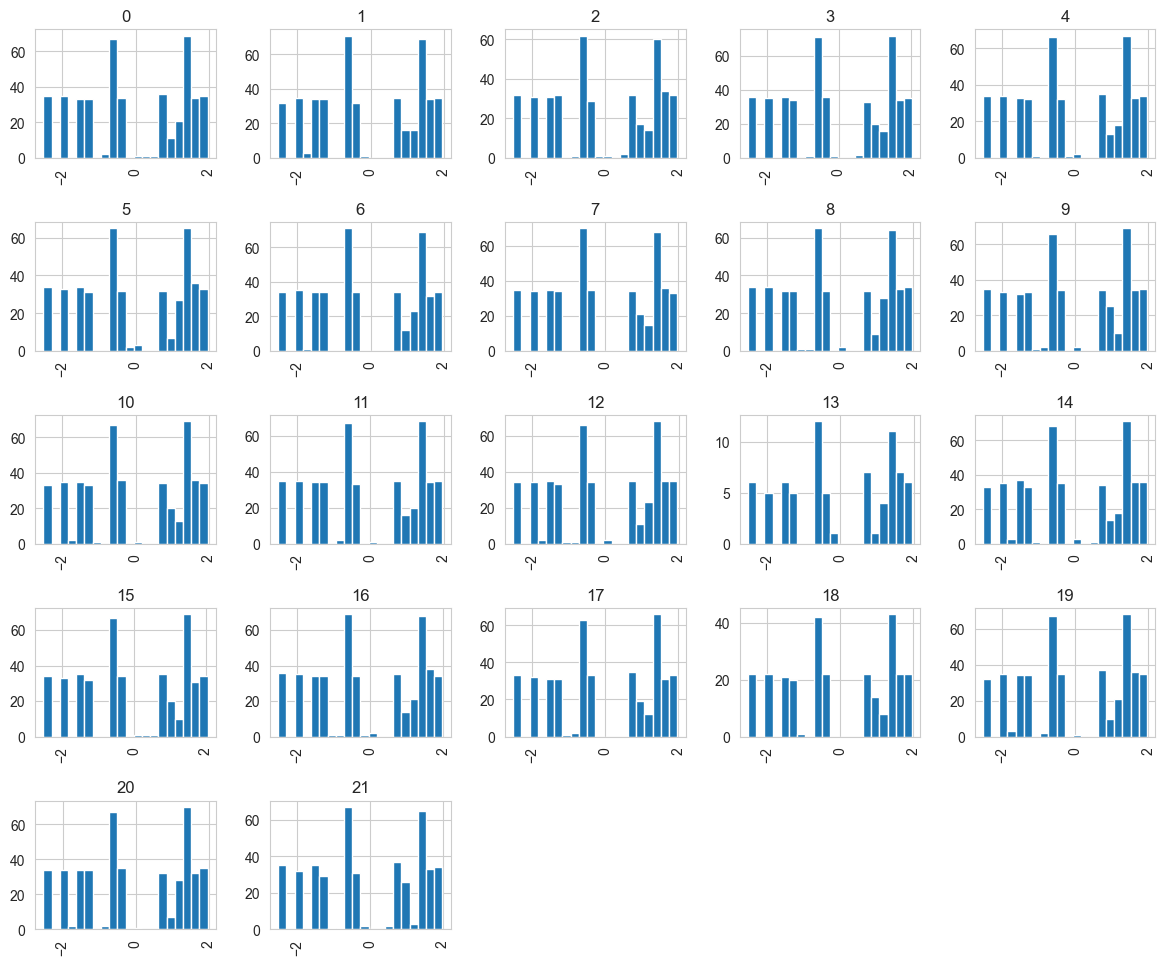

In [24]:
df[['driver', 'mean_yaw']].hist('mean_yaw', by='driver', bins=20, figsize=(14, 12))
plt.show()

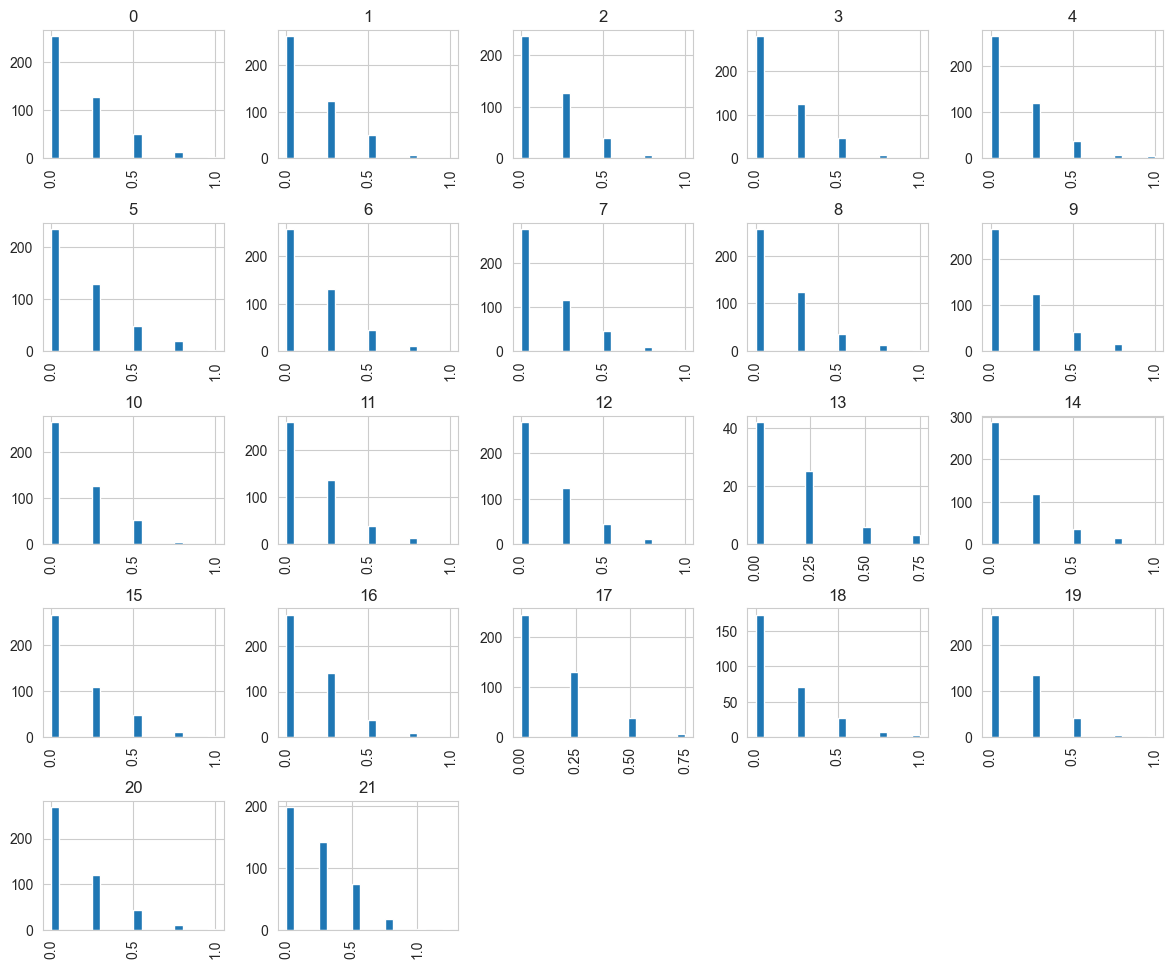

In [25]:
df[['driver', 'tyres_damage']].hist('tyres_damage', by='driver', bins=20, figsize=(14, 12))
plt.show()

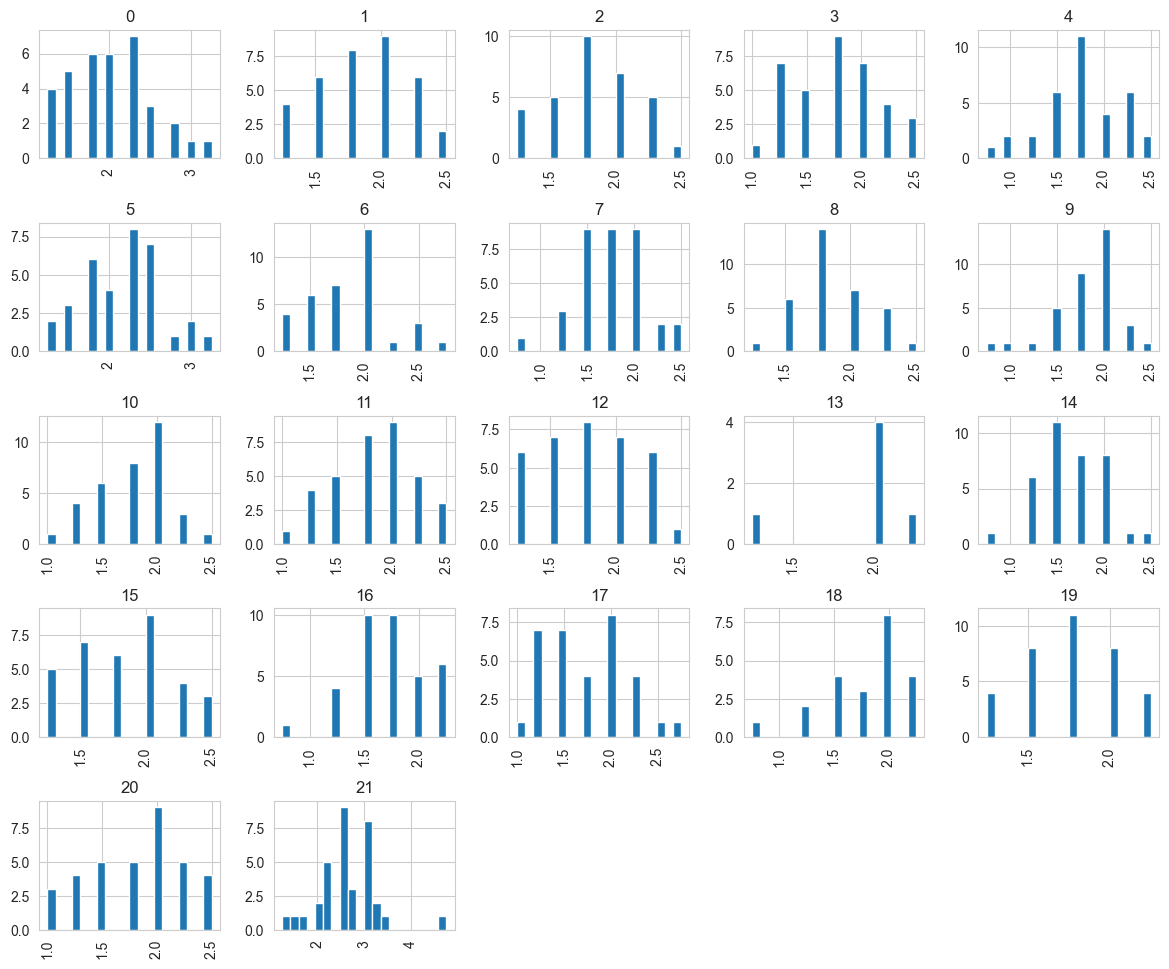

In [26]:
df.groupby(['driver', 'start_lap', 'end_lap'], as_index=False).sum()[['driver', 'tyres_damage']].hist('tyres_damage', by='driver', bins=20, figsize=(14, 12))
plt.show()

In [27]:
tyreConsumption = df.groupby(['driver', 'start_lap', 'end_lap'], as_index=False).sum()[['driver', 'start_lap', 'end_lap', 'tyres_damage']].rename(columns={'tyres_damage': 'tyres_damage_lap'}).reset_index()

df = df.merge(tyreConsumption, how='right', on=['driver', 'start_lap', 'end_lap'])

In [28]:
segments = df['segment'].unique()
columns = [col for col in df.columns if col not in ['driver', 'start_lap', 'end_lap', 'segment', 'lap_time', 'index', 'tyres_damage_lap']]

pivoted = df.pivot_table(
    index=['driver', 'start_lap', 'end_lap'],
    columns='segment',
    values=columns,
    aggfunc='first'
)

pivoted.columns = [f'{col}_{int(seg)}' for col, seg in pivoted.columns]
pivoted = pivoted.reset_index()
main_df = df[['driver', 'start_lap', 'end_lap', 'tyres_damage_lap', 'lap_time']].drop_duplicates()
pivoted_df = main_df.merge(pivoted, on=['driver', 'start_lap', 'end_lap'], how='left')

In [29]:
df_corr = pivoted_df.corr()

In [30]:
df_corr[['tyres_damage_lap', 'lap_time']]

,tyres_damage_lap,lap_time
driver,0.051892,0.018902
start_lap,-0.242036,-0.119718
end_lap,-0.242767,-0.115629
tyres_damage_lap,1.000000,-0.147564
lap_time,-0.147564,1.000000
...,...,...
tyres_damage_9,0.084109,0.069038
tyres_damage_10,-0.001455,0.028297
tyres_damage_11,0.002292,-0.037905
tyres_damage_12,0.247006,-0.074299


In [31]:
selected_columns = [
    'max_g_force_lateral',
    'min_g_force_lateral',
    'mean_g_force_lateral',
    'stddev_g_force_lateral',
    'max_yaw',
    'min_yaw',
    'mean_yaw',
    'stddev_yaw',
]

selected_columns_with_segments = [f'{col}_{int(seg)}' for col, seg in itertools.product(selected_columns, segments)]

<Axes: xlabel='tyres_damage_lap', ylabel='lap_time'>

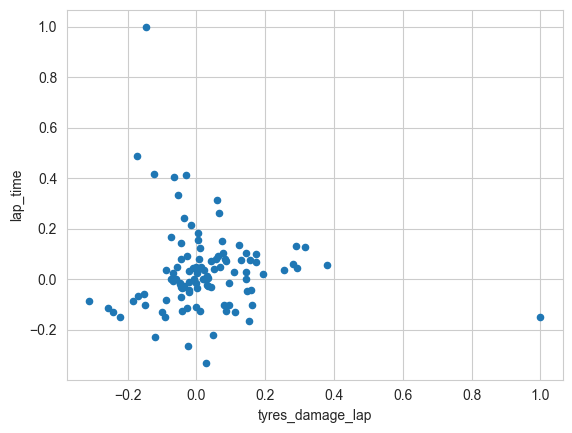

In [32]:
pivoted_df[['tyres_damage_lap', 'lap_time'] + selected_columns_with_segments].corr().plot.scatter(x='tyres_damage_lap', y='lap_time')

In [33]:
filtered_df = pivoted_df[['tyres_damage_lap', 'lap_time'] + selected_columns_with_segments].dropna()
X = filtered_df[selected_columns_with_segments].to_numpy()

In [34]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
df_2dims = pca.fit_transform(X)

df_2dims = pd.DataFrame(df_2dims, columns=[f'd{i}' for i in range(5)])
df_2dims['lap_time'] = filtered_df['lap_time'].to_numpy()
df_2dims['tyres_damage_lap'] = filtered_df['tyres_damage_lap'].to_numpy()

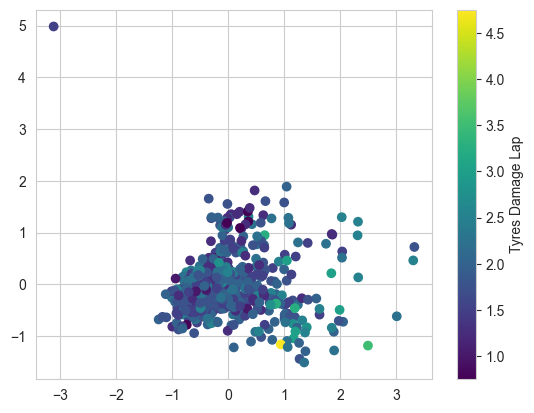

In [35]:
scatter = plt.scatter(df_2dims['d0'], df_2dims['d3'], 
                      c=df_2dims['tyres_damage_lap'], 
                      cmap='viridis')

plt.colorbar(scatter, label='Tyres Damage Lap')

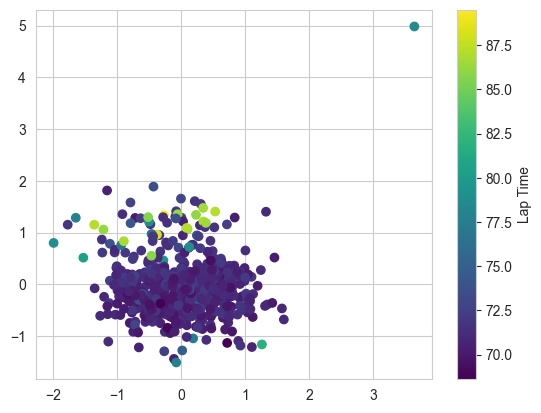

In [36]:
scatter = plt.scatter(df_2dims['d2'], df_2dims['d3'], 
                      c=df_2dims['lap_time'], 
                      cmap='viridis')

plt.colorbar(scatter, label='Lap Time')

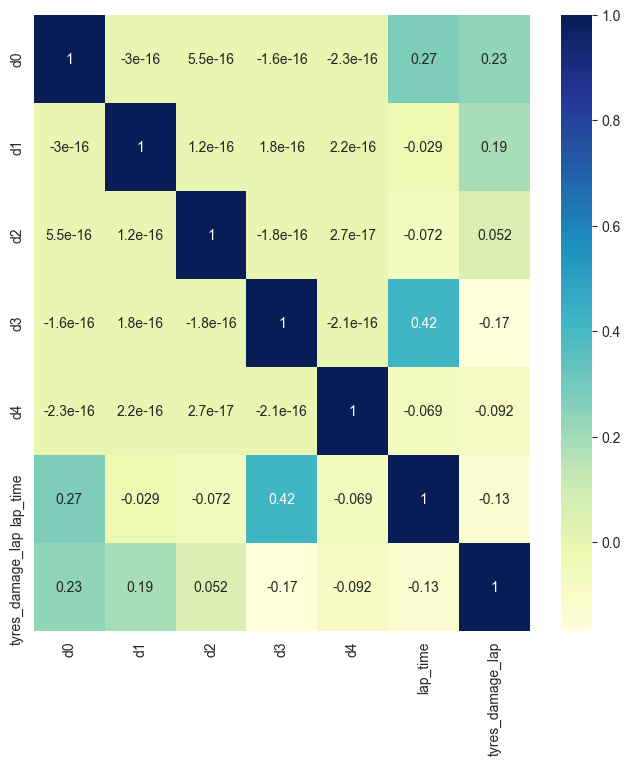

In [37]:
plt.figure(figsize=(8, 8))
dataplot = sb.heatmap(df_2dims.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()

In [38]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_lap'])
df_2dims['tyres_damage_lap_reg'] = reg.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['tyres_damage_lap'].to_numpy(), df_2dims['tyres_damage_lap_reg'].to_numpy())

0.1292362728934069

In [39]:
reg = LinearRegression().fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['lap_time'])
df_2dims['lap_time_reg'] = reg.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['lap_time'].to_numpy(), df_2dims['lap_time_reg'].to_numpy())

0.26081206283347125

In [40]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=1.0, degree=10)
krr.fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_lap'])
df_2dims['tyres_damage_lap_kr'] = krr.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['tyres_damage_lap'].to_numpy(), df_2dims['tyres_damage_lap_kr'].to_numpy())

-16.855412953799153

In [41]:
krr = KernelRidge(alpha=1.0, degree=10)
krr.fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['lap_time'])
df_2dims['lap_time_kr'] = krr.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['lap_time'].to_numpy(), df_2dims['lap_time_kr'].to_numpy())

-633.7232526187736

In [42]:
df_2dims['tyres_damage_lap'].unique()

array([2.5 , 3.25, 2.75, 3.  , 2.  , 1.25, 1.5 , 2.25, 1.75, 1.  , 0.75,
       4.75, 3.5 ], dtype=float32)

In [43]:
bins = [0, 1, 2, 3, 4, 5]
df_2dims['tyres_damage_digitize'] = np.digitize(df_2dims['tyres_damage_lap'], bins) - 1

In [44]:
from sklearn import svm
clf = svm.SVC().fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_digitize'])
clf.score(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_digitize'])

0.5986159169550173

In [47]:
pivoted_df[pivoted_df['driver'] == 21][['start_lap', 'end_lap', 'tyres_damage_lap', 'lap_time']]

,start_lap,end_lap,tyres_damage_lap,lap_time
687,3.787110,82.782349,1.75,78.995239
688,82.782349,154.147598,1.25,71.365250
689,154.147598,224.951477,2.75,70.803879
690,224.951477,295.338318,2.50,70.386841
691,295.338318,365.641510,2.50,70.303192
692,365.641510,436.945862,2.25,71.304352
693,436.945862,518.894287,2.25,81.948425
694,611.553162,681.556213,2.25,70.003052
695,681.556213,763.454529,4.75,81.898315
696,763.454529,832.957031,2.50,69.502502


In [54]:
stints_arrays = []
stints = []
for idx, row in pivoted_df[pivoted_df['driver'] == 21][['start_lap', 'end_lap', 'tyres_damage_lap', 'lap_time']].iterrows():
    if len(stints_arrays) == 0 or (len(stints_arrays) != 0 and stints_arrays[-1]['end_lap'] == row['start_lap']):
        stints_arrays.append(row)
    else:
        stints.append(stints_arrays)
        stints_arrays = [row]
        print(f'Stint index {len(stints) -1 } has {len(stints[-1])}')
stints.append(stints_arrays)
print(f'Stint index {len(stints) -1 } has {len(stints[-1])}')

Stint index 0 has 7
Stint index 1 has 27


In [56]:
longest_stint = list(map(lambda x: x['lap_time'], stints[1]))
longest_stint

[70.00305,
 81.898315,
 69.5025,
 69.88635,
 70.80383,
 70.80383,
 70.90393,
 71.78821,
 71.70471,
 74.79126,
 72.1051,
 71.84656,
 78.39502,
 85.60181,
 69.002075,
 68.668335,
 68.80188,
 68.601685,
 71.40454,
 69.91968,
 69.40234,
 69.78638,
 70.40332,
 71.704834,
 70.50342,
 69.58618,
 71.00391]

In [57]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# The array of values
data = longest_stint

# Prepare the dataset
X = []
y = []
for i in range(len(data) - 4):
    X.append(data[i:i+4])
    y.append(data[i+4])

X = np.array(X)
y = np.array(y)

# Initialize the model
model = LinearRegression()

# Evaluate the model using Leave-One-Out Cross-Validation
loo = LeaveOneOut()
mse_scores = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

print(f"Average MSE: {np.mean(mse_scores)}")

# Train the model on the full dataset
model.fit(X, y)

# Predict the next value using the last four elements
last_four = data[-4:]
predicted_next = model.predict([last_four])

print(f"Predicted next value: {predicted_next[0]:.5f}")


Average MSE: 42.084381103515625
Predicted next value: 71.74699


In [60]:
preditions = model.predict(X)

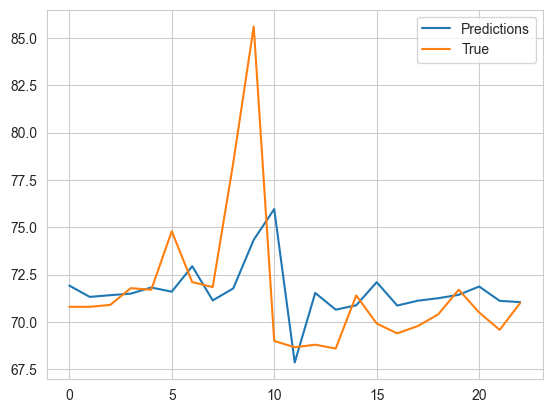

In [62]:
plt.plot(preditions, label='Predictions')
plt.plot(y, label='True')
plt.legend()
plt.show()